# Import libraries

In [25]:
import reservoirpy as rpy
from collections import defaultdict
import seaborn as sns
from reservoirpy.nodes import Ridge, Reservoir, Input
import matplotlib.pyplot as plt
# import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import Ridge as Ridge_sklearn
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
import os

rpy.verbosity(0)  # no need to be too verbose here
rpy.set_seed(23)  # make everything reproducible!

# Data preprocessing and EDA

## Index Domclick

In [39]:
data_mredc_date = pd.read_csv(os.getcwd()+'/data/data_mredc_date.csv', index_col=0)
data_mredc_date['date'] = pd.to_datetime(data_mredc_date['date'], yearfirst=True)
data_mredc_date.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    418 non-null    datetime64[ns]
 1   close   418 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.8 KB


## USD/RUB currency

In [40]:
usd_rub = pd.read_excel(os.getcwd()+'/data/usd_rub.xlsx')
usd_rub.info()
usd_rub.drop(columns=['nominal', 'cdx'], inplace=True)
usd_rub.rename(columns={'data':'date'}, inplace=True)
usd_rub.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2007 entries, 0 to 2006
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   nominal  2007 non-null   int64         
 1   data     2007 non-null   datetime64[ns]
 2   curs     2007 non-null   float64       
 3   cdx      2007 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 62.8+ KB


/Users/roman14/Downloads/Reservoir-Computing-Investigation/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,date,curs
0,2025-02-20,90.4268
1,2025-02-19,91.3398
2,2025-02-18,91.4347
3,2025-02-15,90.3099
4,2025-02-14,91.0313


## Inflation rate

In [41]:
infl = pd.read_excel(os.getcwd()+'/data/infl_msc.xls', decimal='.', skiprows=5, header=None)
infl = infl.iloc[:, 2:].T.rename(columns={0: 'infl'})
new_row = pd.DataFrame({'infl': [100.57]}) # инфляция по г.Москва, Январь 2025 г. к декабрю 2024 г.
infl = pd.concat([infl, new_row], ignore_index=True)
date_infl = pd.date_range('31-01-2017', periods=infl.shape[0], freq='ME')
infl['date'] = date_infl

# инфляция по г.Москва, декабрь 2016 (https://mosreg.ru/sobytiya/novosti/news-submoscow/inflyaciya-v-podmoskove-v-dekabre-proshlogo-goda-sostavila-0-4?utm_referrer=https%3A%2F%2Fwww.google.com%2F)
new_row = pd.DataFrame({'infl': [100.4], 'date': ['2016-12-31']})
new_row['date'] = pd.to_datetime(new_row['date'])
# Объединяем новую строку и исходный DataFrame
infl = pd.concat([new_row, infl], ignore_index=True)
infl.head()

,infl,date
0,100.40,2016-12-31
1,100.77,2017-01-31
2,100.38,2017-02-28
3,100.25,2017-03-31
4,100.42,2017-04-30


In [42]:
infl['infl'] = np.nancumprod(infl['infl']*0.01) #np.exp((infl['infl']*0.01-1).cumsum()) + np.log(1)
infl.head()

,infl,date
0,1.004000,2016-12-31
1,1.011731,2017-01-31
2,1.015575,2017-02-28
3,1.018114,2017-03-31
4,1.022390,2017-04-30


In [43]:
# Устанавливаем дату в индекс
infl.set_index('date', inplace=True)

# Создаем полный еженедельный индекс (по средам)
full_weekly_index = pd.date_range(data_mredc_date['date'].iloc[0], infl.index.max(), freq='D')

# Переиндексируем данные инфляции
infl_reindexed = infl.reindex(full_weekly_index)

# Интерполируем с учетом времени (линейно между месячными точками)
infl_interpolated = infl_reindexed.interpolate(method='time')

# Сбрасываем индекс и переименовываем колонки
infl_weekly = infl_interpolated.reset_index().rename(columns={'index': 'date'})

infl_weekly.head()

,date,infl
0,2016-12-28,NaN
1,2016-12-29,NaN
2,2016-12-30,NaN
3,2016-12-31,1.004000
4,2017-01-01,1.004249


## Merging in one Dataframe

In [44]:
data_mredc_date = data_mredc_date.merge(usd_rub, how='left', on=['date'])
data_mredc_date = data_mredc_date.merge(infl_weekly, how='left', on=['date'])
data_mredc_date.head()

,date,close,curs,infl
0,2016-12-28,159646.69,60.8587,NaN
1,2017-01-04,158952.36,NaN,1.004998
2,2017-01-11,158470.18,59.9533,1.006743
3,2017-01-18,157778.75,59.4015,1.008489
4,2017-01-25,157832.09,59.2168,1.010235


In [45]:
data_mredc_date['curs'].fillna(method='ffill', inplace=True)
data_mredc_date['curs_MA'] = data_mredc_date['curs'].rolling(13).mean()
data_mredc_date['curs_loged'] = np.log(data_mredc_date['curs']).diff()
data_mredc_date['infl_loged'] = np.log(data_mredc_date['infl']).diff()

data_mredc_date['MA_close'] = data_mredc_date['close'].rolling(13).mean()
data_mredc_date['log_return_close'] = np.log(data_mredc_date['close'].rolling(13).mean()).diff()

/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_90117/448299253.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_mredc_date['curs'].fillna(method='ffill', inplace=True)
/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_90117/448299253.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_mredc_date['curs'].fillna(method='ffill', inplace=True)


## Visualization

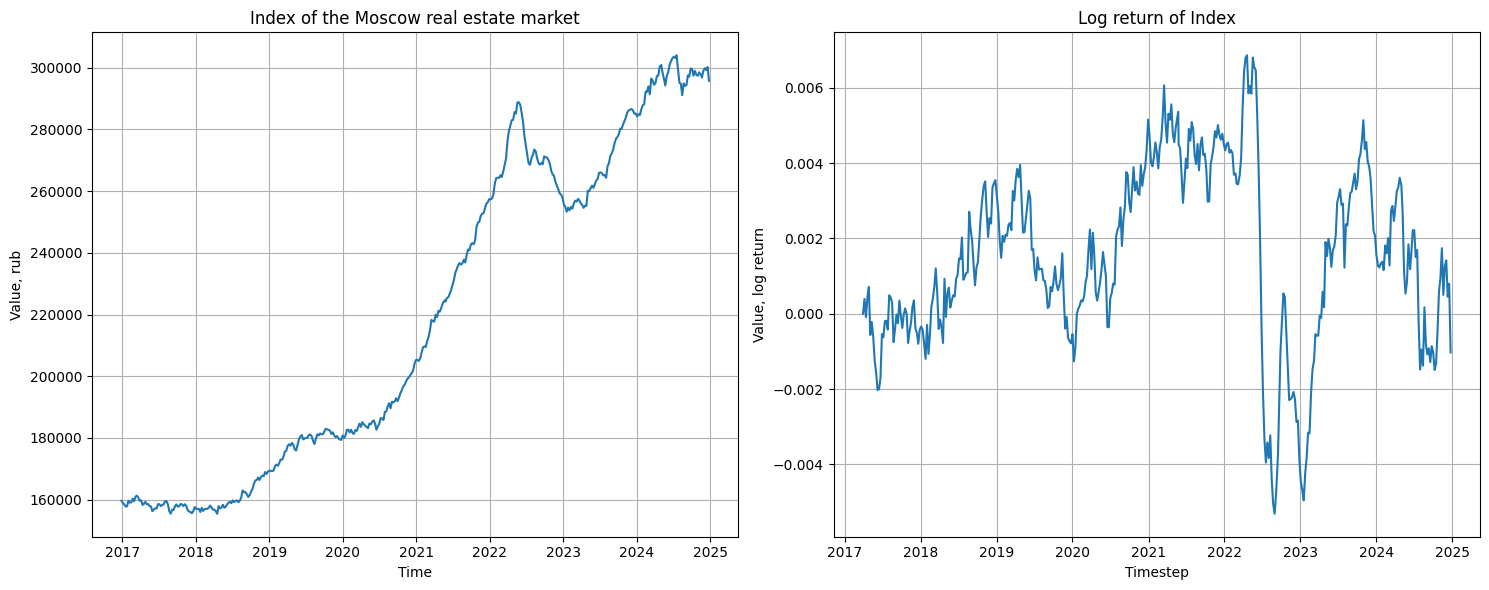

In [22]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(data_mredc_date['date'], data_mredc_date['close'])
plt.ylabel('Value, rub')
plt.xlabel('Time')
plt.title('Index of the Moscow real estate market')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(data_mredc_date['date'][13:], data_mredc_date['log_return_close'].dropna())
plt.ylabel('Value, log return')
plt.xlabel('Timestep')
plt.title('Log return of Index')
plt.grid()

plt.tight_layout()
plt.show()

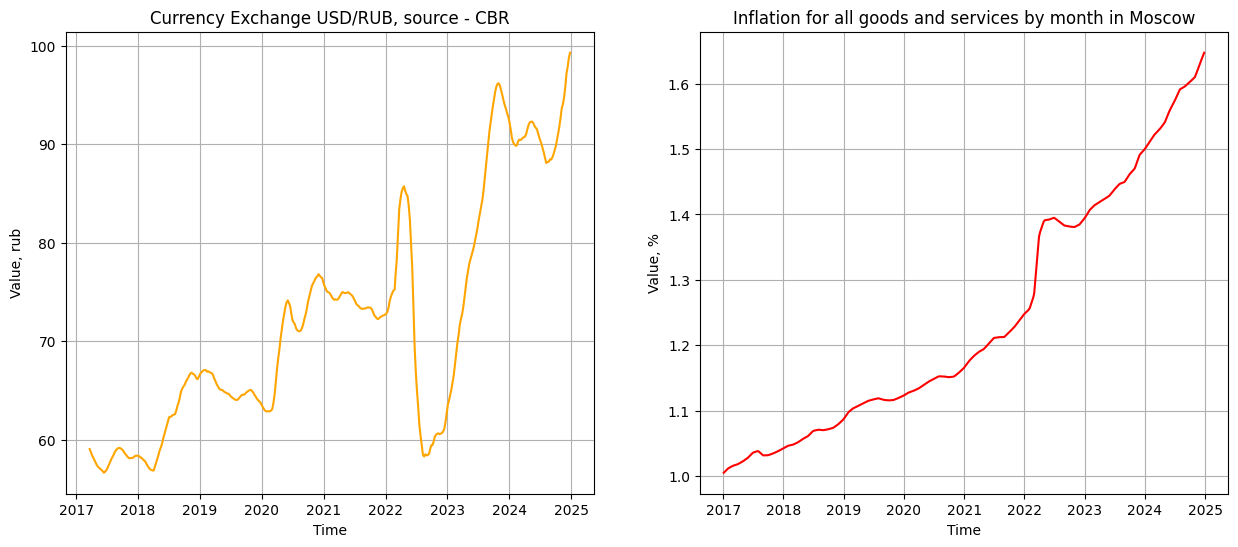

In [23]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(data_mredc_date['date'], data_mredc_date['curs'], color='orange')
plt.title('Currency Exchange USD/RUB, source - CBR')
plt.ylabel('Value, rub')
plt.xlabel('Time')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(data_mredc_date['date'], data_mredc_date['infl'], color='red')
plt.title('Inflation for all goods and services by month in Moscow')
plt.ylabel('Value, %')
plt.xlabel('Time')
plt.grid()

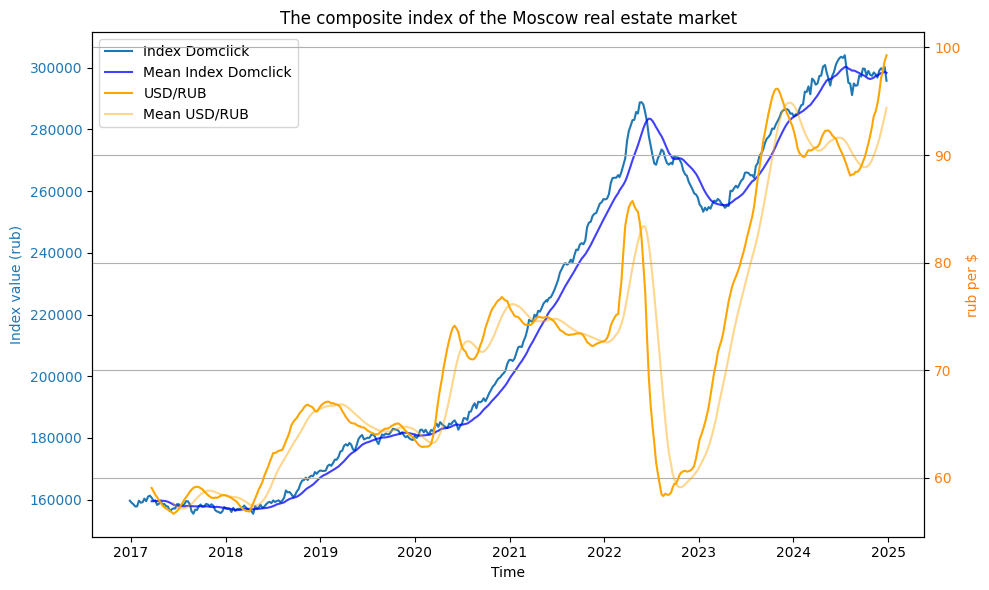

In [24]:
# Создаем фигуру и первую ось (ось Y для рублей)
fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Index value (rub)', color=color1)
ax1.plot(data_mredc_date['date'], data_mredc_date['close'], color=color1, label='Index Domclick')
ax1.plot(data_mredc_date['date'], data_mredc_date['close'].rolling(13).mean(), color='blue', alpha=0.75, label='Mean Index Domclick')
ax1.tick_params(axis='y', labelcolor=color1)

# Создаем вторую ось Y, общую с осью X
ax2 = ax1.twinx()

color2 = 'tab:orange'
ax2.set_ylabel('rub per $', color=color2)
ax2.plot(data_mredc_date['date'], data_mredc_date['curs'], color='orange', label='USD/RUB')
ax2.plot(data_mredc_date['date'], data_mredc_date['curs'].rolling(13).mean(), color='orange', alpha=0.45, label='Mean USD/RUB')
ax2.tick_params(axis='y', labelcolor=color2)

# Добавляем заголовок и отображаем график
plt.title('The composite index of the Moscow real estate market')
fig.tight_layout()
plt.grid()

# Получаем линии и метки с обеих осей
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

# Объединяем и отображаем общую легенду
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

# Define models

In [26]:
class EnhancedESN_FAN:
    def __init__(self,
                 input_dim,
                 reservoir_size=100,
                 spectral_radius=0.9,
                 sparsity=0.1,
                 ridge_alpha=1.0,
                 poly_order=2,
                 fan_dp=5,
                 seed=23):
        """
        input_dim : dimensionality of X (features per timestep)
        fan_dp    : number of Fourier terms (dp in the FAN paper)
        """
        np.random.seed(seed)
        self.reservoir_size = reservoir_size
        self.poly = PolynomialFeatures(degree=poly_order, include_bias=False)
        self.fan_dp = fan_dp

        # placeholders; actual Win/W init happens in fit()
        self.Win = None
        self.W   = None

        self.spectral_radius = spectral_radius
        self.sparsity = sparsity

        self.ridge = Ridge_sklearn(alpha=ridge_alpha)
        self.scaler = StandardScaler()
        self.input_scaler = StandardScaler()

    def initialize_weights(self, X):
        # input‐distribution aware Win
        inp_mean, inp_std = X.mean(axis=0), X.std(axis=0)
        mu, sigma = inp_mean.mean(), inp_std.mean()
        self.Win = np.random.normal(mu, sigma, (self.reservoir_size, X.shape[1] + 1))

        # sparse W with spectral radius
        W = np.random.rand(self.reservoir_size, self.reservoir_size) - 0.5
        W[np.random.rand(*W.shape) > self.sparsity] = 0
        W *= self.spectral_radius / np.max(np.abs(np.linalg.eigvals(W)))
        self.W = W

    def _update(self, state, u):
        # standard ESN update
        pre = self.Win @ np.concatenate(([1], u)) + self.W @ state
        return np.tanh(pre)

    def _fourier_features(self, X):
        # X: (n_samples, n_features)
        # return: (n_samples, 2*fan_dp*n_features)
        # FAN: explicit Fourier series terms sin(2πk x), cos(2πk x)
        features = []
        for k in range(1, self.fan_dp + 1):
            features.append(np.sin(2 * np.pi * k * X))
            features.append(np.cos(2 * np.pi * k * X))
        return np.hstack(features)
    
    # def _fft_features(self, X, n_coeffs):
    #     # X: (T, n) time series
    #     # return first n_coeffs magnitudes per dimension
    #     coeffs = np.abs(fft(X, axis=0))[:n_coeffs]  # shape (n_coeffs, n)
    #     return np.tile(coeffs.flatten(), (X.shape[0], 1))

    def fit(self, X, y):
        """
        X: shape (T, input_dim)
        y: shape (T,) or (T, output_dim)
        """
        # init reservoir
        self.initialize_weights(X)

        # collect reservoir states
        T = X.shape[0]
        states = np.zeros((T, self.reservoir_size))
        state = np.zeros(self.reservoir_size)
        for t in range(T):
            state = self._update(state, X[t])
            states[t] = state

        X_scaled = self.input_scaler.fit_transform(X)
        # polynomial features
        P = self.poly.fit_transform(X_scaled)
        # Fourier analysis network features
        F = self._fourier_features(X_scaled)

        # # combine all
        # H = np.hstack([states, P, F])

        # # scale & fit readout
        # Hs = self.scaler.fit_transform(H)
        # self.ridge.fit(Hs, y)

        H = np.hstack([states, P, F])
        self.scaler.fit(H)
        # prevent division by zero in .transform()
        self.scaler.scale_[self.scaler.scale_ == 0.0] = 1.0
        Hs = self.scaler.transform(H)
        self.ridge.fit(Hs, y)


    def predict(self, X, generative_steps=None):
        """
        If X is (T, input_dim) and generative_steps is None, this is open-loop:
          returns readout(X)
        If generative_steps is an int > 0, we perform:
          - use X[-1] as u0, then recursively predict next u's.
        """
        if generative_steps is None:
            # one‐shot prediction (teacher forcing)
            T = X.shape[0]
            states = np.zeros((T, self.reservoir_size))
            state = np.zeros(self.reservoir_size)
            for t in range(T):
                state = self._update(state, X[t])
                states[t] = state

            P = self.poly.transform(X)
            F = self._fourier_features(X)
            H = np.hstack([states, P, F])
            Hs = self.scaler.transform(H)
            return self.ridge.predict(Hs)

        # generative forecasting
        u = X[-1].copy()      # last observed input
        state = np.zeros(self.reservoir_size)
        preds = []
        for _ in range(generative_steps):
            state = self._update(state, u.reshape(-1))
            # build feature row
            # P = self.poly.transform(u.reshape(1, -1))
            # F = self._fourier_features(u.reshape(1, -1))
            u_scaled = self.input_scaler.transform(u.reshape(1, -1))
            clip = 3.0  # you can tune this (e.g. 3 standard deviations)
            u_scaled = np.clip(u_scaled, -clip, clip)

            P = self.poly.transform(u_scaled)
            F = self._fourier_features(u_scaled)
            h = np.hstack([state, P.ravel(), F.ravel()]).reshape(1, -1)
            h_s = self.scaler.transform(h)
            u_next = self.ridge.predict(h_s)
            preds.append(u_next.ravel())
            u = u_next  # feed back

        return np.vstack(preds)

In [27]:
units = 100
leak_rate = 0.3
spectral_radius = 1.25
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
regularization = 1e-8
seed = 23

In [28]:
def reset_esn(input_dim):
    input_one = Input(input_dim=input_dim)
    reservoir_one = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                        lr=leak_rate, rc_connectivity=connectivity,
                        input_connectivity=input_connectivity, seed=seed)
    
    # reservoir_two = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
    #                     lr=leak_rate, rc_connectivity=connectivity,
    #                     input_connectivity=input_connectivity, seed=seed)
    
    readout_one   = Ridge(input_dim, ridge=regularization)

    return input_one >> reservoir_one >> readout_one

# Cross-validation

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

def cross_validation(
    model_factory,
    time_series,
    time_delta,
    cv_type="expanding",
    window_size=None,
    train_full=True
):
    """
    Perform multi‐step MAPE CV on a 1D series with either expanding or rolling windows,
    working directly on the provided real‐scale time_series.

    Parameters
    ----------
    model_factory : callable
        Constructor for your model (e.g. EnhancedESN_FAN), must accept input_dim=1
        and implement .fit(X,y) and .run(u).
    time_series : pd.Series or 1D array
        The raw input sequence.
    time_delta : int
        Forecast horizon for each fold.
    cv_type : {"expanding","rolling"}
        "expanding": train=[0:fold*Δ], test=next Δ points.
        "rolling" : train=[start:start+window_size], test=next Δ points.
    window_size : int, optional
        Required if cv_type=="rolling". Fixed length of each training window.
    train_full : bool
        If True, refit on the entire series at the end and return that model.

    Returns
    -------
    final_model : object or None
        The model refit on the full series if train_full else None.
    history_mape : List[float]
        One MAPE per fold.
    """
    ts = np.asarray(time_series)
    L = len(ts)

    if cv_type not in ("expanding", "rolling"):
        raise ValueError("cv_type must be 'expanding' or 'rolling'")

    if cv_type == "rolling" and window_size is None:
        raise ValueError("Must specify window_size for rolling CV")
    
    history_mape = []

    if cv_type == "expanding":
        n_folds = L // time_delta
        for fold in range(1, n_folds):
            train_end = fold * time_delta
            test_start = train_end
            test_end   = train_end + time_delta
            if test_end > L:
                break

            # Build train and test slices
            X_tr = ts[:train_end-1].reshape(-1, 1)
            y_tr = ts[1:train_end].reshape(-1, 1)
            y_true = ts[test_start:test_end].reshape(-1, 1)

            # Fit model
            model = model_factory
            model.fit(X_tr, y_tr)

            # Generative Δ-step forecast
            preds = model.predict(y_tr, generative_steps=time_delta)
            # Compute MAPE
            mape = mean_absolute_percentage_error(y_true, preds) * 100
            history_mape.append(mape)

    else:  # rolling
        max_start = L - window_size - time_delta
        for start in range(0, max_start + 1, drop_step):
            train_start = start
            train_end   = start + window_size
            test_start  = train_end
            test_end    = test_start + time_delta
            if test_end > L:
                break

            X_tr = ts[train_start:train_end-1].reshape(-1, 1)
            y_tr = ts[train_start+1:train_end].reshape(-1, 1)
            y_true = ts[test_start:test_end].reshape(-1, 1)

            model = model_factory
            model.fit(X_tr, y_tr)

            preds = model.predict(y_tr, generative_steps=time_delta)
            # Compute MAPE
            mape = mean_absolute_percentage_error(y_true, preds) * 100
            history_mape.append(mape)

    final_model = None
    if train_full:
        X_all = ts[:-1].reshape(-1,1)
        y_all = ts[1: ].reshape(-1,1)
        final_model = model_factory.fit(X_tr, y_tr)

    return final_model, history_mape

## One-dimensional

In [49]:
esn_fan = EnhancedESN_FAN(input_dim=1, reservoir_size=300, spectral_radius=0.9,
                      sparsity=0.5, ridge_alpha=1e-2, poly_order=3, fan_dp=7, seed=23)

In [46]:
data_mredc_date[['date','close', 'curs', 'infl']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    418 non-null    datetime64[ns]
 1   close   418 non-null    float64       
 2   curs    418 non-null    float64       
 3   infl    417 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 13.2 KB


In [122]:
model_one, one_history = cross_validation(esn_fan, data_mredc_date['MA_close'].dropna(), time_delta=13, train_full=False)

In [ ]:
model_one_sch2, one_history_sch2 = cross_validation(esn_fan, data_mredc_date['MA_close'].dropna(), time_delta=13, train_full=False, cv_type='rolling', window_size=)

## Multivariate

In [75]:
def cross_validation_multi(
    model_factory,
    time_series,
    time_delta,
    cv_type="expanding",
    window_size=None,
    train_full=True
):
    """
    Perform multi-step MAPE cross-validation on multivariate time series,
    computing MAPE individually for each variable.

    Parameters
    ----------
    model_factory : callable
        Constructor for EnhancedESN_FAN, accepts input_dim and provides methods fit(X,y) and predict(X, generative_steps).
    time_series : pd.DataFrame or np.ndarray
        Multivariate series (shape: [T, num_features]).
    time_delta : int
        Forecast horizon per fold.
    cv_type : {"expanding", "rolling"}
        Cross-validation type.
    window_size : int, optional
        Training window size if rolling CV.
    train_full : bool
        Train on full data after CV if True.

    Returns
    -------
    final_model : object or None
        Model trained on full series if train_full else None.
    history_mape : dict
        Dict of variable-wise MAPE lists per fold.
    """
    ts = np.asarray(time_series)
    num_obs, num_features = ts.shape

    if cv_type not in ("expanding", "rolling"):
        raise ValueError("cv_type must be 'expanding' or 'rolling'")

    if cv_type == "rolling" and window_size is None:
        raise ValueError("Must specify window_size for rolling CV")

    history_mape = {f"var_{i}": [] for i in range(num_features)}

    if cv_type == "expanding":
        n_folds = num_obs // time_delta
        for fold in range(1, n_folds):
            train_end = fold * time_delta
            test_start = train_end
            test_end = train_end + time_delta

            if test_end > num_obs:
                break

            X_tr = ts[:train_end-1]
            y_tr = ts[1:train_end]
            y_true = ts[test_start:test_end]

            model = model_factory
            model.fit(X_tr, y_tr)

            preds = model.predict(y_tr, generative_steps=time_delta)

            for i in range(num_features):
                mape = mean_absolute_percentage_error(y_true[:, i], preds[:, i]) * 100
                history_mape[f"var_{i}"].append(mape)

    else:  # rolling
        max_start = num_obs - window_size - time_delta
        for start in range(0, max_start + 1, time_delta):
            train_start = start
            train_end = start + window_size
            test_start = train_end
            test_end = test_start + time_delta

            X_tr = ts[train_start:train_end-1]
            y_tr = ts[train_start+1:train_end]
            y_true = ts[test_start:test_end]

            model = model_factory(input_dim=num_features)
            model.fit(X_tr, y_tr[:, 0])

            current_input = X_tr[-1, :].reshape(1, -1)
            preds = []
            for _ in range(time_delta):
                pred_step = model.predict(current_input, generative_steps=1)
                preds.append(pred_step.ravel())
                current_input = np.roll(current_input, shift=-1, axis=0)
                current_input[0, 0] = pred_step[0, 0]

            preds = np.array(preds)

            for i in range(num_features):
                mape = mean_absolute_percentage_error(y_true[:, i], preds[:, i]) * 100
                history_mape[f"var_{i}"].append(mape)

    final_model = None
    if train_full:
        X_all = ts[:-1]
        y_all = ts[1:, 0]
        final_model = model_factory(input_dim=num_features)
        final_model.fit(X_all, y_all)

    return final_model, history_mape


In [85]:
esn_fan_multi = EnhancedESN_FAN(input_dim=3, reservoir_size=300, spectral_radius=0.9,
                      sparsity=0.5, ridge_alpha=1e-2, poly_order=3, fan_dp=7, seed=23)

In [77]:
data_mredc_date.columns

Index(['date', 'close', 'curs', 'infl', 'curs_MA', 'curs_loged', 'infl_loged',
       'MA_close', 'log_return_close'],
      dtype='object')

In [119]:
model_multi, multi_history = cross_validation_multi(esn_fan_multi, data_mredc_date[['MA_close', 'curs_loged', 'infl_loged']].dropna().values, time_delta=13, train_full=False)

(0.0, 5.0)

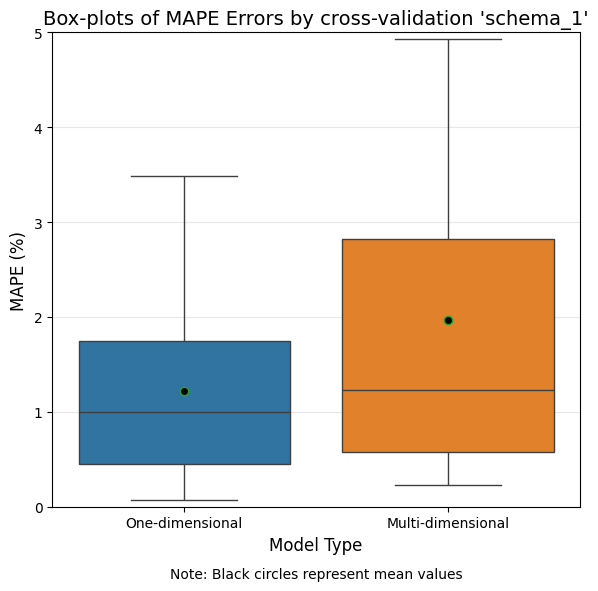

In [ ]:
# Создаем DataFrame для визуализации
data = pd.DataFrame({
    'One-dimensional': np.array(one_history[:]),
    'Multi-dimensional': np.array(multi_history['var_0']),
})

# Преобразуем данные в длинный формат
data_melted = data.melt(var_name='Model', value_name='MAPE')

# Настраиваем размер графика
plt.figure(figsize=(6, 6))

# Рисуем boxplot
sns.boxplot(
    x='Model', 
    y='MAPE', 
    data=data_melted,
    hue='Model',
    legend=False,
    showmeans=True,  # Показываем средние значения
    meanprops={'marker':'o', 'markerfacecolor':'black'}
)

# Добавляем заголовок и подписи
plt.title("Box-plots of MAPE Errors by cross-validation (expanding)", fontsize=14)
plt.xlabel("Model Type", fontsize=12)
plt.ylabel("MAPE (%)", fontsize=12)
plt.grid(True, axis='y', alpha=0.3)

# Добавляем аннотации
plt.text(
    x=0.5, y=-0.15, 
    s='Note: Black circles represent mean values',
    fontsize=10, ha='center', transform=plt.gca().transAxes
)

plt.tight_layout()
plt.ylim(0,5)